# Impacts of enabling encryption within AWS

Not measuring or reporting on bandwidth as it was all about the same regardless of the profile (SSE,SSL). Data analysed for presentation to SWOT/NISAR EESDS group [available here](https://docs.google.com/presentation/d/1Wh2aZyyrOfZAC9H1vTs8IGX_TVjT0BBT-jSQRn7dO0Y/).

In [2]:
# PREAMBLE
%matplotlib inline
create_external_graphs = False

import re
import io
import os.path
import statistics
from functools import reduce

import pandas as pd

import numpy as np

from ggplot import *

## CPU

Measuring relative performance and resource utilization using the [AWS CLI](https://aws.amazon.com/cli/). See [Test Environment Setup](Test%20Environment%20Setup.ipynb#AWS-CLI) for more details.

Color legend for graphs:

<span style="color:red; font-size:24px">■</span> **no_ssl_cpu** - Transfer to S3 with TLS/SSL *disabled* and Server Side Encryption *disabled*<br>
<span style="color:blue; font-size:24px">■</span> **yes_ssl_cpu** - Transfer to S3 with TLS/SSL *enabled* and Server Side Encryption *disabled*<br>
<span style="color:green; font-size:24px">■</span> **yes_sse_cpu** - Transfer to S3 with TLS/SSL *enabled* and Server Side Encryption *enabled*

### 8 Concurrent Uploads

In [3]:
# PROCESS SAR CPU METRICS
FIND_CPU = re.compile(".+ all .+")
CPU_COLS = ["cpu"]
SAMPLES = 25
SAMPLE_RANGE = range(1, SAMPLES)
REPORTS_DATA_DIR = "report_data"

cpu_df = lambda fname: pd.read_fwf(io.StringIO("".join(filter(FIND_CPU.match, open(fname)))), header=None)\
                             .loc[:,[8]]

async_no_ssl_cpus = tuple(cpu_df(os.path.join(REPORTS_DATA_DIR, "async_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
async_yes_ssl_cpus = tuple(cpu_df(os.path.join(REPORTS_DATA_DIR, "async_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
async_yes_sse_cpus = tuple(cpu_df(os.path.join(REPORTS_DATA_DIR, "async_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in async_no_ssl_cpus + async_yes_sse_cpus + async_yes_ssl_cpus:
    df.columns = CPU_COLS

async_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_no_ssl_cpus, 1)})
async_no_ssl_cpu.df_name = "no_ssl_cpu"
async_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_ssl_cpus, 1)})
async_yes_ssl_cpu.df_name = "yes_ssl_cpu"
async_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(async_yes_sse_cpus, 1)})
async_yes_sse_cpu.df_name = "yes_sse_cpu"

async_cpu = [async_no_ssl_cpu, async_yes_ssl_cpu, async_yes_sse_cpu]
for i in range(len(async_cpu)):
    df_name = async_cpu[i].df_name
    async_cpu[i]["t"] = async_cpu[i].index
    async_cpu[i] = pd.melt(async_cpu[i], ["t"], var_name="run", value_name=async_cpu[i].df_name)
    async_cpu[i].df_name = df_name

async_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), async_cpu), 
                       id_vars=["t","run"],
                       value_name="cpu",
                       var_name="run_type"
                      )

What the data looks like

In [4]:
async_cpu_df.head()

,t,run,run_type,cpu
0,0,s1,no_ssl_cpu,0.03
1,1,s1,no_ssl_cpu,43.73
2,2,s1,no_ssl_cpu,80.28
3,3,s1,no_ssl_cpu,88.08
4,4,s1,no_ssl_cpu,58.67


After 20 test runs, the average CPU utilization is:

In [5]:
async_cpu_df[["run_type", "cpu"]].groupby(["run_type"]).mean()

,cpu
run_type,
no_ssl_cpu,6.993352
yes_sse_cpu,19.106114
yes_ssl_cpu,10.722649


Average test length

In [6]:
pd.DataFrame([
        statistics.mean(len(s) for s in async_no_ssl_cpus),
        statistics.mean(len(s) for s in async_yes_ssl_cpus),
        statistics.mean(len(s) for s in async_yes_sse_cpus)
    ],["no_ssl_cpu", "yes_ssl_cpu", "yes_sse_cpu"], ["secs"])

,secs
no_ssl_cpu,433.541667
yes_ssl_cpu,441.291667
yes_sse_cpu,442.708333


You can see how that plays out in a time series view of the CPU utilization.

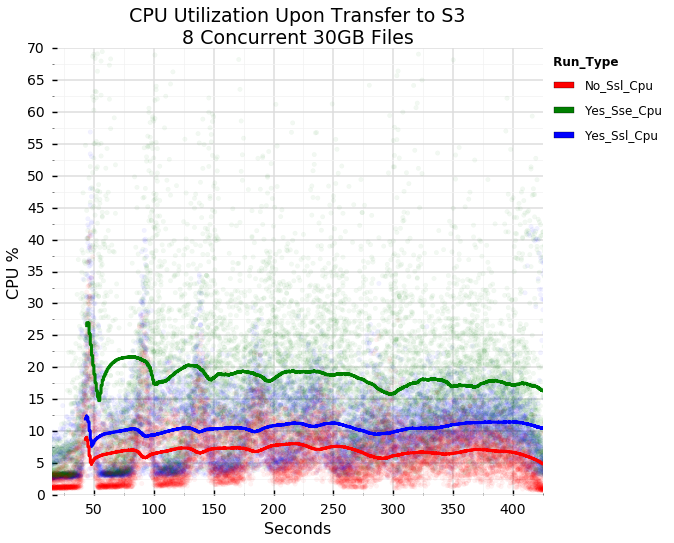

<ggplot: (8728557538438)>

In [7]:
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=async_cpu_df) +\
    stat_smooth(size=3,  alpha=1, se=False, method="ma") +\
    geom_jitter(alpha=.05) +\
    xlim(15,425) +\
    ylim(0,70) +\
    xlab("Seconds") +\
    ylab("CPU %") +\
    ggtitle("CPU Utilization Upon Transfer to S3\n8 Concurrent 30GB Files") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/network-cpu-1.png", s, dpi=96)
s

Here is a density graph showing the distribution of CPU utilization values across the various run types.

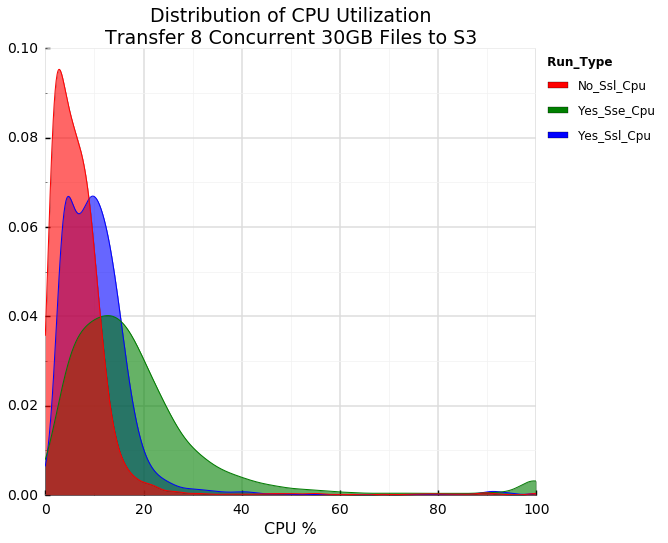

<ggplot: (8728607877012)>

In [8]:
s = ggplot(aes(x='cpu', color='run_type', fill='run_type'), data=async_cpu_df) +\
    geom_density(alpha=.6) +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    xlab("CPU %") +\
    ggtitle("Distribution of CPU Utilization\nTransfer 8 Concurrent 30GB Files to S3") +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/network-cpu-2.png", s, dpi=96)
s

### Single File Upload

A more realistic scenario.

In [9]:
# PROCESS SAR CPU METRICS
SAMPLES = 28
SAMPLE_RANGE = range(SAMPLES)

single_no_ssl_cpus = tuple(cpu_df(os.path.join(REPORTS_DATA_DIR, "single_no_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                          for i in SAMPLE_RANGE)
single_yes_ssl_cpus = tuple(cpu_df(os.path.join(REPORTS_DATA_DIR, "single_yes_ssl_no_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)
single_yes_sse_cpus = tuple(cpu_df(os.path.join(REPORTS_DATA_DIR, "single_yes_ssl_yes_sse-cpu.{}.sar.txt".format(i)))
                           for i in SAMPLE_RANGE)

for df in single_no_ssl_cpus + single_yes_sse_cpus + single_yes_ssl_cpus:
    df.columns = CPU_COLS

single_no_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_no_ssl_cpus)})
single_no_ssl_cpu.df_name = "no_ssl_cpu"
single_yes_ssl_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_ssl_cpus)})
single_yes_ssl_cpu.df_name = "yes_ssl_cpu"
single_yes_sse_cpu = pd.DataFrame({"s{}".format(i): 100-df.cpu for (i,df) in enumerate(single_yes_sse_cpus)})
single_yes_sse_cpu.df_name = "yes_sse_cpu"

single_cpu = [single_no_ssl_cpu, single_yes_ssl_cpu, single_yes_sse_cpu]

for i in range(len(single_cpu)):
    df_name = single_cpu[i].df_name
    single_cpu[i]["t"] = single_cpu[i].index
    single_cpu[i] = pd.melt(single_cpu[i], ["t"], var_name="run", value_name=single_cpu[i].df_name)
    single_cpu[i].df_name = df_name

single_cpu_df = pd.melt(reduce(lambda x,y: pd.merge(x, y, on=["t","run"]), single_cpu), 
             id_vars=["t","run"],
             value_name="cpu",
             var_name="run_type",
)

What the data looks like

In [10]:
single_cpu_df.head()

,t,run,run_type,cpu
0,0,s0,no_ssl_cpu,0.03
1,1,s0,no_ssl_cpu,26.24
2,2,s0,no_ssl_cpu,0.49
3,3,s0,no_ssl_cpu,0.59
4,4,s0,no_ssl_cpu,0.53


Average CPU Utilization

In [11]:
single_cpu_df[["run_type", "cpu"]].groupby(["run_type"]).mean()

,cpu
run_type,
no_ssl_cpu,2.787438
yes_sse_cpu,6.641715
yes_ssl_cpu,3.440253


Average test length

In [12]:
pd.DataFrame([
        statistics.mean(len(s) for s in single_no_ssl_cpus),
        statistics.mean(len(s) for s in single_yes_ssl_cpus),
        statistics.mean(len(s) for s in single_yes_sse_cpus)],["no_ssl_cpu", "yes_ssl_cpu", "yes_sse_cpu"], ["secs"])

,secs
no_ssl_cpu,99.821429
yes_ssl_cpu,140.857143
yes_sse_cpu,136.857143


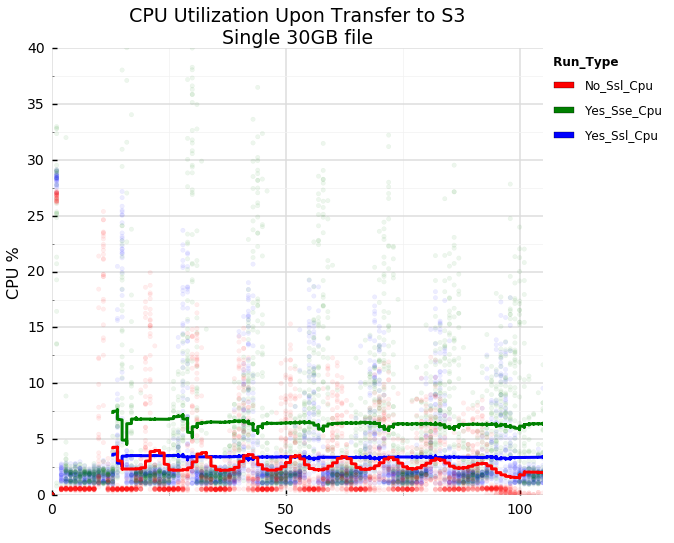

<ggplot: (8728558513770)>

In [13]:
s = ggplot(aes(x='t', y='cpu', color='run_type', fill='run_type'),
           data=single_cpu_df) +\
    stat_smooth(size=3,  alpha=1, se=False, method="ma", window=375) +\
    geom_jitter(alpha=.07) +\
    xlim(0,105) +\
    ylim(0,40) +\
    xlab("Seconds") +\
    ylab("CPU %") +\
    ggtitle("CPU Utilization Upon Transfer to S3\nSingle 30GB file") +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    theme_seaborn(context='talk', style="whitegrid")

if create_external_graphs: ggsave("/tmp/single-network-cpu-1.png", s, dpi=96)
s

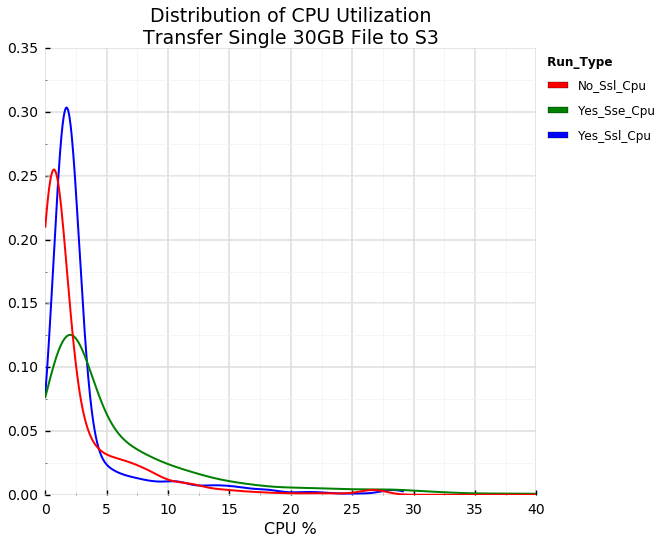

<ggplot: (-9223363308296209881)>

In [14]:
s = ggplot(aes(x='cpu', color='run_type'), data=single_cpu_df) +\
    geom_density(alpha=.6, size=2) +\
    scale_color_manual(values=["red", "green", "blue"]) +\
    xlab("CPU %") +\
    xlim(0,40) +\
    ggtitle("Distribution of CPU Utilization\nTransfer Single 30GB File to S3") +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/single-network-cpu-3.png", s, dpi=96)
s

---

## Disk I/O

Here we are measuring (via [bonnie++](https://www.coker.com.au/bonnie++/)) the relative performace of encrypted disks ([LUKS](https://gitlab.com/cryptsetup/cryptsetup/blob/master/README.md) for [ephemeral](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/InstanceStorage.html) and [SSE](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/EBSEncryption.html) for [EBS](https://aws.amazon.com/ebs/)) vs. non encrypted disks for storage of potentially sensitive data and regulatory compliance.

In [15]:
# Process Bonnie Data
samples = []
for dev in ("eph-p", "eph-e", "io-e", "io-p"): 
    with open(os.path.join(REPORTS_DATA_DIR, "bonnie.{}.txt".format(dev)), "r") as f:
        samples.extend(dev.split("-") + l.strip().split(",") for l in f.readlines()[1:])

bonnie = pd.DataFrame(samples)[[0,1,11, 12, 13,17, 18, 39, 40,]+list(range(42,50))]
bonnie.columns=["dev_type", "enc_flag", "put_block", "put_block_cpu", "rewrite", "get_block",
"get_block_cpu", "put_block_latency","rewrite_latency",
"get_block_latency","seeks_latency","seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency","ran_stat_latency","ran_del_latency"]

for l in ("put_block", "get_block", "put_block_cpu", "get_block_cpu"):
    bonnie[l] = bonnie[l].apply(int)
    
for l in ("put_block_latency", "get_block_latency","rewrite_latency","seeks_latency",
          "seq_create_latency","seq_stat_latency","seq_del_latency","ran_create_latency",
          "ran_stat_latency","ran_del_latency"):
    bonnie[l] = bonnie[l].apply(lambda x: int(x[:-2]) if x[-2:] == "us" else int(x[:-2])*1000)

What the data looks like

In [16]:
bonnie.head()

,dev_type,enc_flag,put_block,put_block_cpu,rewrite,get_block,get_block_cpu,put_block_latency,rewrite_latency,get_block_latency,seeks_latency,seq_create_latency,seq_stat_latency,seq_del_latency,ran_create_latency,ran_stat_latency,ran_del_latency
0,eph,p,439625,28,180121,439533,14,22803,458000,20886,4909,136000,274,347000,152000,41,282000
1,eph,p,440489,29,181749,439541,14,26011,378000,15698,389,138000,272,253000,138000,49,287000
2,eph,p,433757,28,178483,439745,14,26556,403000,9400,575,154000,447,215000,137000,47,244000
3,eph,p,406842,27,178898,439132,14,38160,404000,21083,2004,141000,272,231000,162000,49,301000
4,eph,p,407786,27,180905,428006,13,28688,432000,21548,1731,155000,272,300000,150000,48,289000


Averages after 20 test runs

In [17]:
bonnie.groupby(["dev_type","enc_flag"]).mean()

put_block  put_block_cpu  get_block  get_block_cpu  \
dev_type enc_flag                                                       
eph      e         401970.35          30.05  301238.50           10.0   
         p         417092.60          27.20  429359.20           13.6   
io       e         122070.30           7.15  159317.15            5.0   
         p         122065.95           7.70  159151.05            4.7   

                   put_block_latency  rewrite_latency  get_block_latency  \
dev_type enc_flag                                                          
eph      e                2899500.00        3055150.0           16969.05   
         p                  27703.40         408050.0           19099.90   
io       e                  63924.15         831950.0          225400.00   
         p                  70670.00         614350.0          207350.00   

                   seeks_latency  seq_create_latency  seq_stat_latency  \
dev_type enc_flag                                                        
eph      e               1353.95            158950.0            315.30   
         p               2321.35            150950.0            293.70   
io       e               7081.40            163400.0            289.35   
         p              10491.50            132500.0            288.55   

                   seq_del_latency  ran_create_latency  ran_stat_latency  \
dev_type enc_flag                                                          
eph      e                345850.0            152800.0             44.20   
         p                277850.0            145550.0             44.45   
io       e               3376650.0            167700.0             46.15   
         p               3439750.0            143100.0             45.70   

                   ran_del_latency  
dev_type enc_flag                   
eph      e                324500.0  
         p                294150.0  
io       e               2748400.0  
         p               2757200.0

Dev types
+ eph -> Ephemeral
+ io -> EBS

Color legend for graphs:

<span style="color:red; font-size:24px">■</span> **p** - Plaintext<br>
<span style="color:green; font-size:24px">■</span> **e** - Encrypted at rest (LUKS in the case of eph, KMS SSE in the case of EBS)

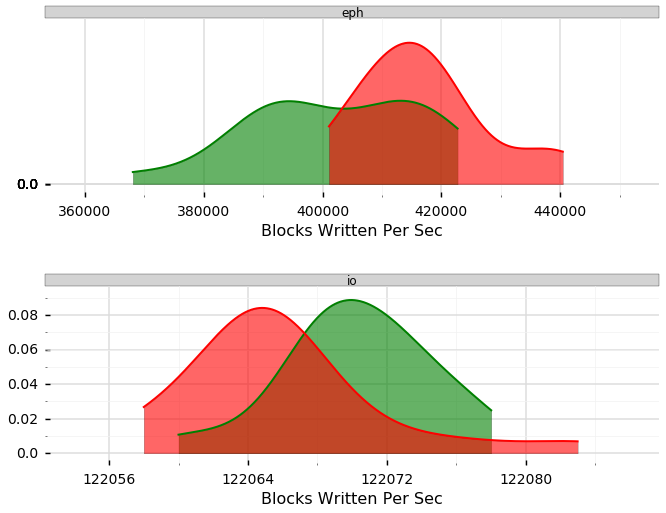

<ggplot: (-9223363308296322451)>

In [18]:
s = ggplot(aes(x="put_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type") +\
    scale_color_manual(values=["green", "red"]) +\
    xlab("Blocks Written Per Sec") +\
    theme_seaborn(context='talk',style="whitegrid")

if create_external_graphs: ggsave("/tmp/disk-io-3.png", s, dpi=96)
s

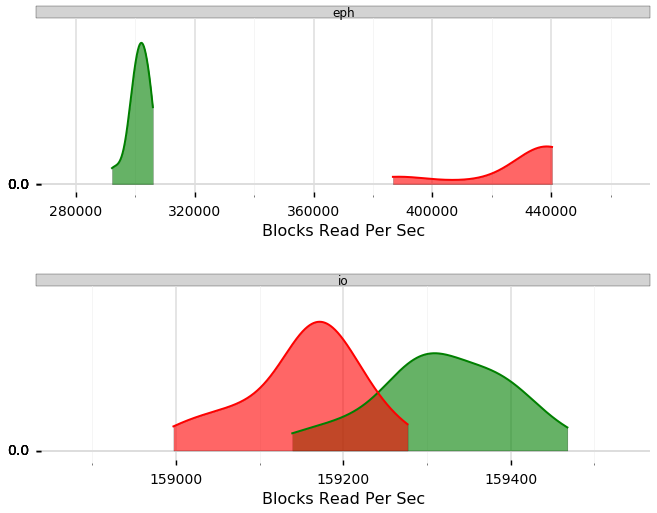

<ggplot: (8728558571717)>

In [19]:
s = ggplot(aes(x="get_block", color="enc_flag", fill="enc_flag"), data=bonnie) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("dev_type") +\
    xlab("Blocks Read Per Sec") +\
    scale_color_manual(values=["green", "red"])+\
    theme_seaborn(style="whitegrid",context='talk')

if create_external_graphs: ggsave("/tmp/disk-io-5.png", s, dpi=96)
s

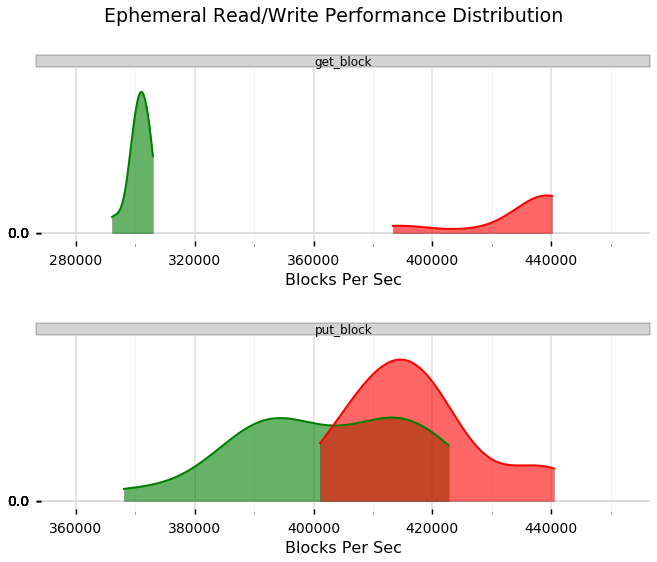

<ggplot: (-9223363308296394773)>

In [20]:
dd = pd.melt(bonnie[bonnie.dev_type == "eph"][["enc_flag","put_block","get_block"]], 
        id_vars=["enc_flag"], 
        value_vars=["put_block","get_block"],
        var_name="action",
        value_name="blks"
       )
s = ggplot(aes(x="blks", color="enc_flag", fill="enc_flag"), data=dd) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("action") +\
    scale_color_manual(values=["green", "red"])+\
    ggtitle("Ephemeral Read/Write Performance Distribution") +\
    xlab("Blocks Per Sec") +\
    theme_seaborn(style="whitegrid",context='talk')
if create_external_graphs: ggsave("/tmp/disk-io-6.png", s, dpi=96)
s

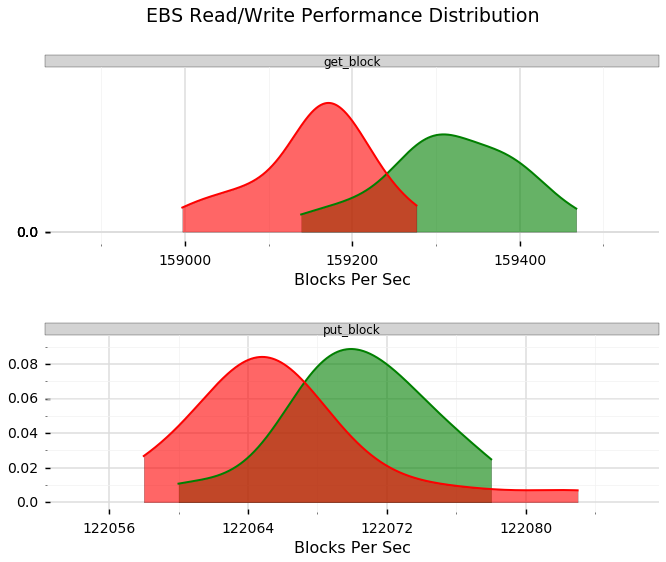

<ggplot: (-9223363308297039486)>

In [21]:
dd = pd.melt(bonnie[bonnie.dev_type == "io"][["enc_flag","put_block","get_block"]], 
        id_vars=["enc_flag"], 
        value_vars=["put_block","get_block"],
        var_name="action",
        value_name="blks"
       )
s = ggplot(aes(x="blks", color="enc_flag", fill="enc_flag"), data=dd) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("action") +\
    scale_color_manual(values=["green", "red"])+\
    ggtitle("EBS Read/Write Performance Distribution") +\
    xlab("Blocks Per Sec") +\
    theme_seaborn(style="whitegrid",context='talk')
if create_external_graphs: ggsave("/tmp/disk-io-7.png", s, dpi=96)
s

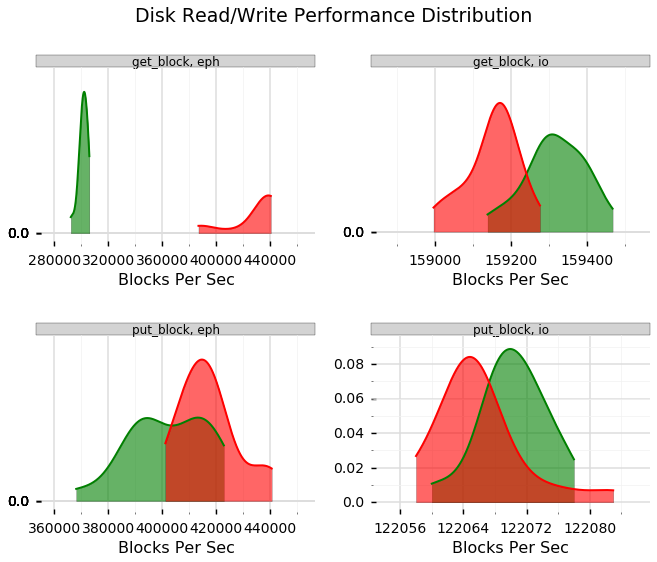

<ggplot: (-9223363308297002317)>

In [22]:
dd = pd.melt(bonnie[["dev_type", "enc_flag","put_block","get_block"]], 
        id_vars=["dev_type", "enc_flag"], 
        value_vars=["put_block","get_block"],
        var_name="action",
        value_name="blks"
       )
s = ggplot(aes(x="blks", color="enc_flag", fill="enc_flag"), data=dd) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("action", "dev_type") +\
    scale_color_manual(values=["green", "red"])+\
    ggtitle("Disk Read/Write Performance Distribution") +\
    xlab("Blocks Per Sec") +\
    theme_seaborn(style="whitegrid",context='talk')
if create_external_graphs: ggsave("/tmp/disk-io-8.png", s, dpi=96)
s

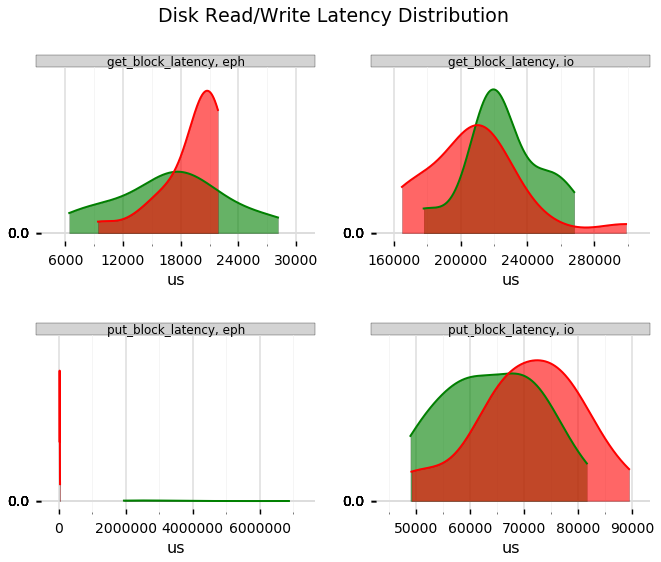

<ggplot: (-9223363308297005971)>

In [23]:
dd = pd.melt(bonnie[["dev_type", "enc_flag","put_block_latency","get_block_latency"]], 
        id_vars=["dev_type", "enc_flag"], 
        value_vars=["put_block_latency","get_block_latency"],
        var_name="action",
        value_name="us"
       )
s = ggplot(aes(x="us", color="enc_flag", fill="enc_flag"), data=dd) +\
    geom_density(alpha=.6, size=2) +\
    facet_wrap("action", "dev_type") +\
    scale_color_manual(values=["green", "red"])+\
    ggtitle("Disk Read/Write Latency Distribution") +\
    theme_seaborn(style="whitegrid",context='talk')
if create_external_graphs: ggsave("/tmp/disk-io-9.png", s, dpi=96)
s

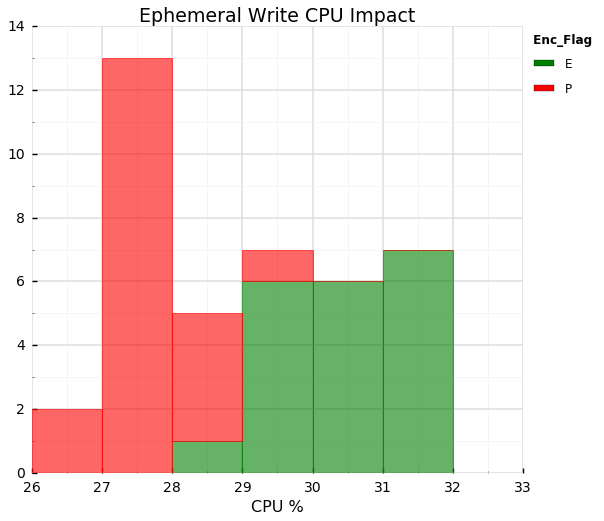

<ggplot: (8728557743466)>

In [24]:
s = ggplot(aes(x="put_block_cpu", color="enc_flag", fill="enc_flag"), 
       data=bonnie[(bonnie.dev_type == "eph")][["enc_flag", "put_block_cpu"]]) +\
    geom_histogram(alpha=.6, binwidth=1) +\
    scale_color_manual(values=["green", "red"])+\
    ggtitle("Ephemeral Write CPU Impact") +\
    xlab("CPU %") +\
    theme_seaborn(style="whitegrid",context='talk')
if create_external_graphs: ggsave("/tmp/disk-io-10.png", s, dpi=96)
s

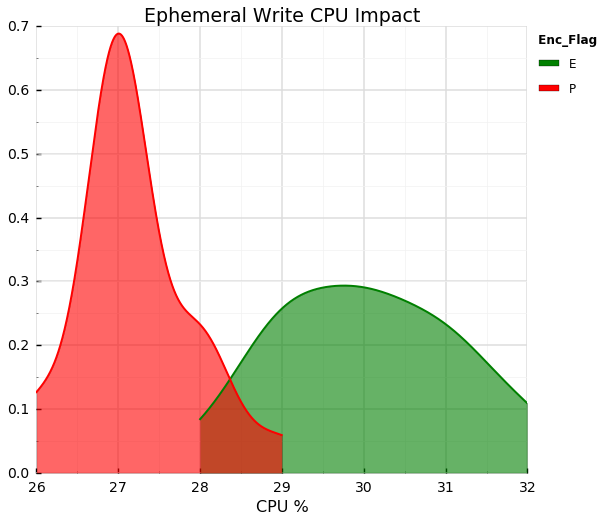

<ggplot: (8728556478535)>

In [25]:
s = ggplot(aes(x="put_block_cpu", color="enc_flag", fill="enc_flag"), 
       data=bonnie[(bonnie.dev_type == "eph")][["enc_flag", "put_block_cpu"]]) +\
    geom_density(alpha=.6, size=2) +\
    scale_color_manual(values=["green", "red"])+\
    ggtitle("Ephemeral Write CPU Impact") +\
    xlab("CPU %") +\
    theme_seaborn(style="whitegrid",context='talk')
if create_external_graphs: ggsave("/tmp/disk-io-11.png", s, dpi=96)
s

stat_bin: binwidth defaulted to range/30.
    Use 'binwidth = x' to adjust this.


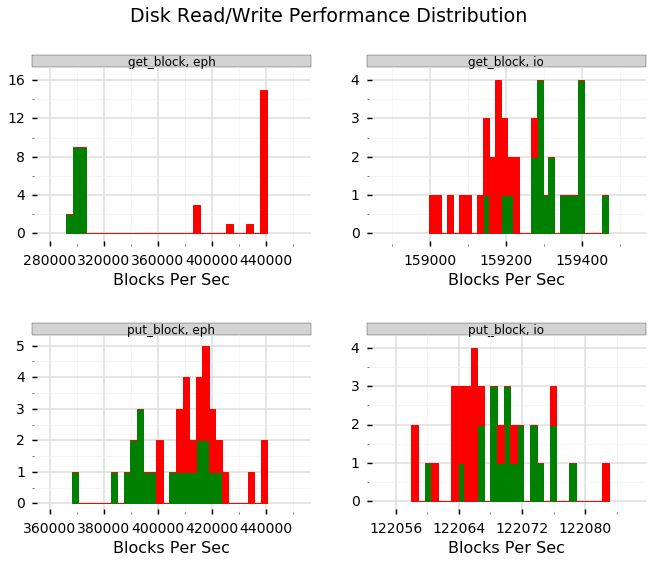

<ggplot: (-9223363308296278205)>

In [26]:
dd = pd.melt(bonnie[["dev_type", "enc_flag","put_block","get_block"]], 
        id_vars=["dev_type", "enc_flag"], 
        value_vars=["put_block","get_block"],
        var_name="action",
        value_name="blks"
       )
s = ggplot(aes(x="blks", color="enc_flag", fill="enc_flag"), data=dd) +\
    geom_histogram() +\
    facet_wrap("action", "dev_type") +\
    scale_color_manual(values=["green", "red"])+\
    ggtitle("Disk Read/Write Performance Distribution") +\
    xlab("Blocks Per Sec") +\
    theme_seaborn(style="whitegrid",context='talk')
if create_external_graphs: ggsave("/tmp/disk-io-12.png", s, dpi=96)
s